In [1]:
import pandas as pd

# Caminho do arquivo original
file_path = 'C:\\Users\\diego\\Projetos\\rfm-analysis\\data\\raw\\online_retail_II.csv'

# Leitura do Excel
df = pd.read_csv(file_path)

# Visualização inicial
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [2]:
# Informações iniciais do dataset
df.info()

# Remove registros sem identificação de cliente
df = df[df['Customer ID'].notna()]

# Remove devoluções e valores inválidos
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Converte data para datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Cria valor total da linha (quantidade * preço)
df['TotalPrice'] = df['Quantity'] * df['Price']

# Converte Customer ID para inteiro
df['Customer ID'] = df['Customer ID'].astype(int)

# Confirma o tipo
df['Customer ID'].dtype

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  str    
 1   StockCode    1067371 non-null  str    
 2   Description  1062989 non-null  str    
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  str    
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 65.1 MB
<class 'pandas.DataFrame'>
Index: 805549 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  str           
 1   StockCode    805549 non-null  str           
 2   Description  805549 non-null  str           
 3   Quantity     805549 non-null  int64         
 4   

In [3]:
# Define a data de referência como a última compra do dataset
lastpurchase_date = df['InvoiceDate'].max()
lastpurchase_date


Timestamp('2011-12-09 12:50:00')

In [4]:
# Cria a tabela RFM agregando os dados por cliente
rfm = (
    df.groupby('Customer ID')
      .agg({
          # Recency: dias desde a última compra do cliente
          'InvoiceDate': lambda x: (lastpurchase_date - x.max()).days,
          
          # Frequency: número de pedidos distintos realizados
          'Invoice': 'nunique',
          
          # Monetary: valor total gasto pelo cliente
          'TotalPrice': 'sum'
      })
      .reset_index()
)

# Renomeia colunas para um padrão analítico
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Visualiza resultado final
rfm.head()

,customer_id,recency,frequency,monetary
0,12346,325,12,77556.46
1,12347,1,8,5633.32
2,12348,74,5,2019.40
3,12349,18,4,4428.69
4,12350,309,1,334.40


In [5]:
# Verificação rápida recency ≥ 0, frequency ≥ 1, monetary > 0

rfm.describe()



,customer_id,recency,frequency,monetary
count,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,200.331916,6.289384,3018.616737
std,1715.572666,209.338707,13.009406,14737.731040
min,12346.000000,0.000000,1.000000,2.950000
25%,13833.250000,25.000000,1.000000,348.762500
50%,15314.500000,95.000000,3.000000,898.915000
75%,16797.750000,379.000000,7.000000,2307.090000
max,18287.000000,738.000000,398.000000,608821.650000


In [6]:
# Score de Recency
# Clientes mais recentes recebem score mais alto

rfm['R_score'] = pd.qcut(
    rfm['recency'], 4,
    labels=[4, 3, 2, 1]
)
print(rfm.head())

'''
pd.qcut() divide os dados em 4 grupos com o mesmo número de clientes recency menor → melhor cliente

Por isso os labels estão invertidos.

Exemplo:
Quartil com menor recency → score 4
Quartil com maior recency → score 1

'''

   customer_id  recency  frequency  monetary R_score
0        12346      325         12  77556.46       2
1        12347        1          8   5633.32       4
2        12348       74          5   2019.40       3
3        12349       18          4   4428.69       4
4        12350      309          1    334.40       2


'\npd.qcut() divide os dados em 4 grupos com o mesmo número de clientes recency menor → melhor cliente\n\nPor isso os labels estão invertidos.\n\nExemplo:\nQuartil com menor recency → score 4\nQuartil com maior recency → score 1\n\n'

In [7]:
# Cria bins de Frequency sem labels
rfm['F_score'] = pd.qcut(
    rfm['frequency'],
    q=4,
    duplicates='drop'
)

print(rfm.head())

# Converte os intervalos em scores numéricos ordenados
rfm['F_score'] = rfm['F_score'].cat.codes + 1


print(rfm.head())

''' A distribuição de Frequency é altamente concentrada em poucos valores.
O qcut resultou em apenas 3 bins válidos, o que reflete o comportamento
real dos clientes. Optou-se por não forçar um quarto bin artificial.
'''

rfm.groupby('F_score')['frequency'].describe()

   customer_id  recency  frequency  monetary R_score       F_score
0        12346      325         12  77556.46       2  (7.0, 398.0]
1        12347        1          8   5633.32       4  (7.0, 398.0]
2        12348       74          5   2019.40       3    (3.0, 7.0]
3        12349       18          4   4428.69       4    (3.0, 7.0]
4        12350      309          1    334.40       2  (0.999, 3.0]
   customer_id  recency  frequency  monetary R_score  F_score
0        12346      325         12  77556.46       2        3
1        12347        1          8   5633.32       4        3
2        12348       74          5   2019.40       3        2
3        12349       18          4   4428.69       4        2
4        12350      309          1    334.40       2        1


,count,mean,std,min,25%,50%,75%,max
F_score,,,,,,,,
1,3231.0,1.703188,0.787353,1.0,1.0,1.0,2.0,3.0
2,1348.0,5.176558,1.093946,4.0,4.0,5.0,6.0,7.0
3,1299.0,18.851424,23.493439,8.0,9.5,12.0,20.0,398.0


In [8]:
# Score de Monetary
# Clientes que gastaram mais recebem score mais alto
rfm['M_score'] = pd.qcut(
    rfm['monetary'],
    4,
    labels=[1, 2, 3, 4]
)
print(rfm.head())

rfm['M_score'].value_counts().sort_index()


   customer_id  recency  frequency  monetary R_score  F_score M_score
0        12346      325         12  77556.46       2        3       4
1        12347        1          8   5633.32       4        3       4
2        12348       74          5   2019.40       3        2       3
3        12349       18          4   4428.69       4        2       4
4        12350      309          1    334.40       2        1       1


M_score
1    1470
2    1469
3    1469
4    1470
Name: count, dtype: int64

In [9]:
# Função que define o segmento de cada cliente com base nos scores RFM
def rfm_segment(row):

    # Champions:
    # Clientes recentes, frequentes e com alto valor monetário
    if (
        row['R_score'] >= 4 and
        row['F_score'] == 3 and
        row['M_score'] >= 4
    ):
        return 'Champions'

    # Loyal Customers:
    # Clientes com alta frequência, mesmo que não sejam tão recentes
    elif row['F_score'] == 3:
        return 'Loyal Customers'

    # New Customers:
    # Clientes que compraram recentemente, mas ainda têm baixa frequência
    elif row['R_score'] == 4 and row['F_score'] == 1:
        return 'New Customers'

    # At Risk:
    # Clientes que não compram há muito tempo
    elif row['R_score'] == 1:
        return 'At Risk'

    # Demais clientes
    else:
        return 'Others'


In [10]:
#Aplicar a segmentação

# Aplica a segmentação a cada linha do DataFrame
rfm['segment'] = rfm.apply(rfm_segment, axis=1)

# Visualiza resultado
rfm.head()

,customer_id,recency,frequency,monetary,R_score,F_score,M_score,segment
0,12346,325,12,77556.46,2,3,4,Loyal Customers
1,12347,1,8,5633.32,4,3,4,Champions
2,12348,74,5,2019.40,3,2,3,Others
3,12349,18,4,4428.69,4,2,4,Others
4,12350,309,1,334.40,2,1,1,Others


In [11]:
#Validação da segmentação

#Clientes por segmento
rfm['segment'].value_counts()

segment
Others             2741
At Risk            1431
Loyal Customers     663
Champions           636
New Customers       407
Name: count, dtype: int64

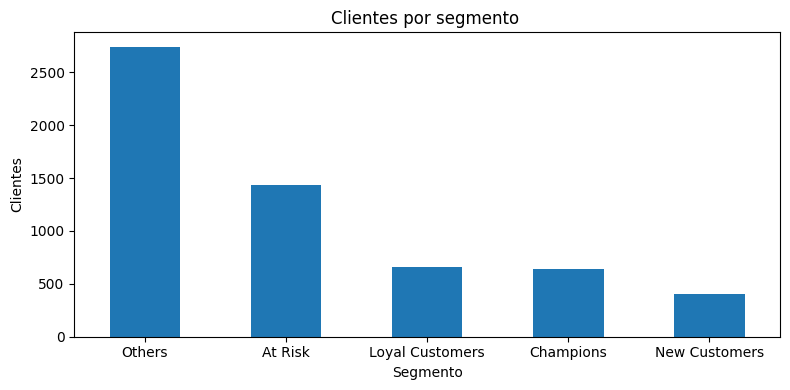

In [12]:
#Visualização simples

import matplotlib.pyplot as plt

rfm['segment'].value_counts().plot(
    kind='bar',
    figsize=(8, 4),
    title='Clientes por segmento '
)

plt.ylabel('Clientes')
plt.xlabel('Segmento')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
# Receita por segmento
# Soma do valor monetário por segmento
revenue_by_segment = (
    rfm.groupby('segment')['monetary']
       .sum()
       .sort_values(ascending=False)
)

revenue_by_segment

segment
Champions          9538987.144
Loyal Customers    3515858.595
Others             3341255.687
At Risk             895691.202
New Customers       451636.550
Name: monetary, dtype: float64

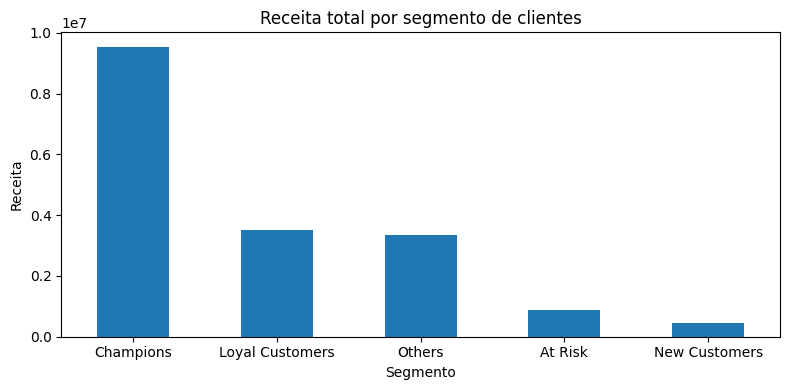

In [14]:
#Visualização simples

import matplotlib.pyplot as plt

revenue_by_segment.plot(
    kind='bar',
    figsize=(8, 4),
    title='Receita total por segmento de clientes'
)

plt.ylabel('Receita')
plt.xlabel('Segmento')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Recomendações de negócio

📣 Recomendações por segmento

🟢 Champions

Objetivo: retenção e aumento de LTV

-Programas VIP
-Benefícios exclusivos
-Early access a produtos
-Comunicação personalizada

📌 Nunca fazer promoção agressiva aqui.

🟡 Loyal Customers

Objetivo: transformar em Champions

-Cross-sell
-Bundles

Incentivos para aumentar ticket médio

🔴 At Risk

Objetivo: reativação

-Campanhas de win-back
-Cupons com validade curta
-Pesquisa de churn (por que deixaram de comprar?)

📌 Segmento com maior ROI potencial.

🔵 New Customers

Objetivo: engajamento inicial

-Boas-vindas
-Educação sobre produtos
-Incentivo à 2ª compra (crítica)

⚪ Others

Objetivo: monitoramento

-Comunicação genérica
-Testes A/B

Não priorizar investimento alto